In [147]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn
from sklearn.decomposition import PCA

# Load data and create datasets

In [148]:
datastore = h5py.File('/Users/driscoll/Dropbox/research/tearfilm/thermal/inverse/trials_many_alldata_v3.h5', 'r')
batch_size = 100
n_comp = 40

raw_I = np.array(datastore["I"])
raw_T = np.array(datastore["T"])
raw_c = np.array(datastore["c"])

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


/var/folders/gc/0752xrm56pnf0r0dsrn5370c0000gr/T/ipykernel_60352/2234837651.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  raw_I = np.array(datastore["I"])
/var/folders/gc/0752xrm56pnf0r0dsrn5370c0000gr/T/ipykernel_60352/2234837651.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  raw_T = np.array(datastore["T"])
/var/folders/gc/0752xrm56pnf0r0dsrn5370c0000gr/T/ipykernel_60352/2234837651.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  raw_c = np.array(datastore["c"])


Using mps device


In [87]:
norm_T = (raw_T - raw_T.min()) / (raw_T.max() - raw_T.min())
raw_in = np.hstack((raw_I, norm_T)).reshape(-1, 2, raw_I.shape[1])
data_in = torch.tensor(raw_in).to(device)

# Downsample the osmolarity
data_out = torch.tensor(raw_c[:,::2]).to(device)

dataset = TensorDataset(data_in, data_out)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model

In [127]:
class VarTransform(nn.Module):
    def __init__(self):
        super(VarTransform, self).__init__()

    def forward(self, x):
        # exp of the 4th input value; pass others unchanged
        x[:, 3] = torch.exp(x[:, 3])
        return x

class net(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(2, 4, 5),
            # nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Conv1d(4, 6, 5),
            # nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Conv1d(6, 8, 5),
            # nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Conv1d(8, 8, 5),
            # nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Flatten(),
            nn.Linear(64, 100),
            nn.Tanh(),
            nn.Linear(100, 200),
            nn.Tanh(),
            nn.Linear(200, output_dim),
        )

    def forward(self, x):
        y = self.layers(x)
        return y
    


In [128]:
n_t = data_out.shape[1]
model = net(n_t).to(device)
print(model)
model(data_in[:4]).shape


net(
  (layers): Sequential(
    (0): Conv1d(2, 4, kernel_size=(5,), stride=(1,))
    (1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (2): Conv1d(4, 6, kernel_size=(5,), stride=(1,))
    (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (4): Conv1d(6, 8, kernel_size=(5,), stride=(1,))
    (5): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (6): Conv1d(8, 8, kernel_size=(5,), stride=(1,))
    (7): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=64, out_features=100, bias=True)
    (10): Tanh()
    (11): Linear(in_features=100, out_features=200, bias=True)
    (12): Tanh()
    (13): Linear(in_features=200, out_features=101, bias=True)
  )
)


torch.Size([4, 101])

# Training

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: Avg loss = {test_loss:>8f} \n")

In [129]:
learning_rate = 2e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 80
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 12.677009  [  100/89250]
loss: 2.416207  [10100/89250]
loss: 1.960533  [20100/89250]
loss: 1.297400  [30100/89250]
loss: 1.027551  [40100/89250]
loss: 0.935582  [50100/89250]
loss: 0.742240  [60100/89250]
loss: 0.748080  [70100/89250]
loss: 0.626695  [80100/89250]
Test Error: Avg loss = 0.658627 

Epoch 2
-------------------------------
loss: 0.662456  [  100/89250]
loss: 0.421759  [10100/89250]
loss: 0.496176  [20100/89250]
loss: 0.448025  [30100/89250]
loss: 0.509273  [40100/89250]
loss: 0.378710  [50100/89250]
loss: 0.311886  [60100/89250]
loss: 0.268253  [70100/89250]
loss: 0.305588  [80100/89250]
Test Error: Avg loss = 0.275013 

Epoch 3
-------------------------------
loss: 0.341649  [  100/89250]
loss: 0.266789  [10100/89250]
loss: 0.385496  [20100/89250]
loss: 0.170603  [30100/89250]
loss: 0.286858  [40100/89250]
loss: 0.325210  [50100/89250]
loss: 0.241049  [60100/89250]
loss: 0.159044  [70100/89250]
loss: 0.258458  [80100/89250]
T

KeyboardInterrupt: 

# Inspecting results

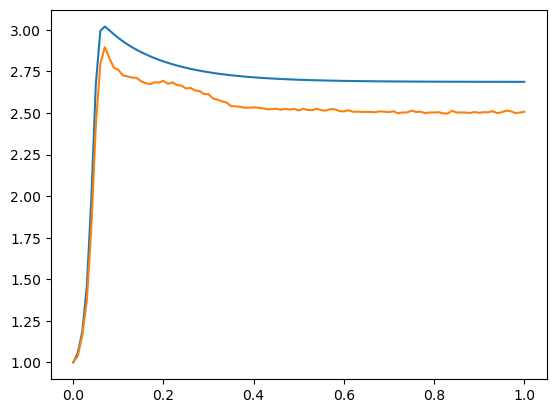

In [140]:
t = np.linspace(0, 1, n_t, dtype=np.float32)
example = 1177
with torch.no_grad():
    x, y = test_dataset[example:example+1]
    plt.plot(t, y[0].cpu())
    plt.plot(t, model(x).cpu()[0])
plt.show()

# RMS error in time series

In [131]:
n_t = len(t)
with torch.no_grad():
    test_osmo_pred = np.zeros((0, n_t))
    test_osmo_actual = np.zeros((0, n_t))
    for (x, y) in test_dataloader:
        test_osmo_pred = np.vstack((test_osmo_pred, model(x).cpu()))
        test_osmo_actual = np.vstack((test_osmo_actual, y.cpu()))
    # train_osmo_pred = np.zeros((0, n_t))
    # train_osmo_actual = np.zeros((0, n_t))
    # for (x, y) in train_dataloader:
    #     train_osmo_pred = np.vstack((train_osmo_pred, model(x).cpu()))
    #     train_osmo_actual = np.vstack((train_osmo_actual, y.cpu()))

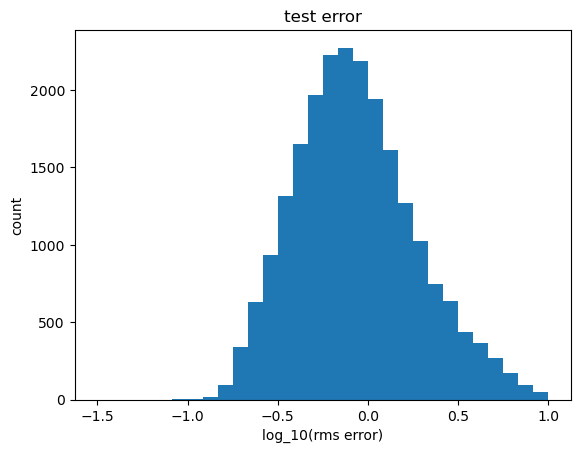

In [132]:
rmserror = np.apply_along_axis(np.linalg.norm, 1, test_osmo_pred - test_osmo_actual)
plt.hist(np.log10(rmserror), bins=np.linspace(-1.5,1,31))
plt.xlabel('log_10(rms error)')
plt.ylabel('count')
plt.title('test error')
plt.show()

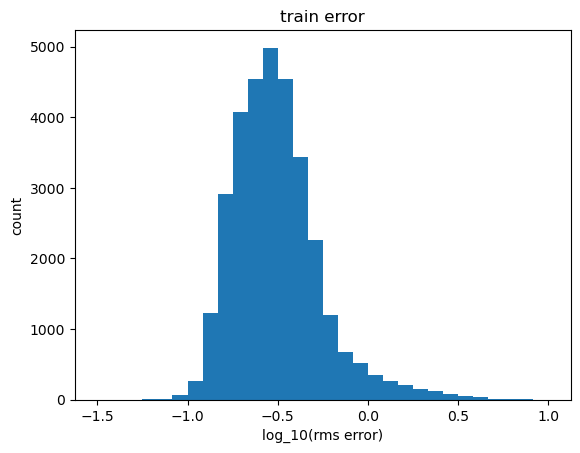

In [16]:
rmserror = np.apply_along_axis(np.linalg.norm, 1, train_osmo_pred - train_osmo_actual)
plt.hist(np.log10(rmserror), bins=np.linspace(-1.5,1,31))
plt.xlabel('log_10(rms error)')
plt.ylabel('count')
plt.title('train error')
plt.show()

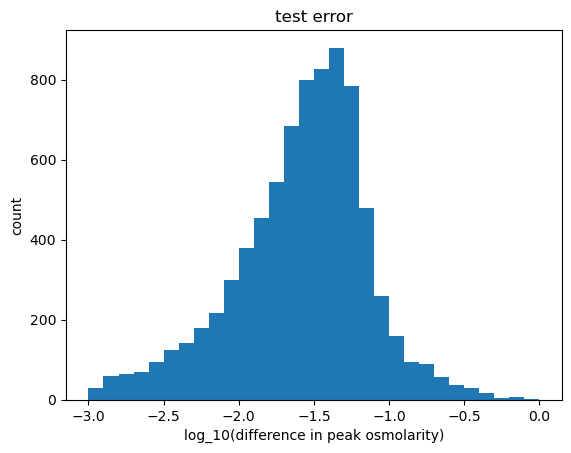

In [17]:
peakerror = np.max(test_osmo_pred, axis=1) - np.max(test_osmo_actual, axis=1)
plt.hist(np.log10(np.abs(peakerror)), bins=np.linspace(-3,0,31))
plt.xlabel('log_10(difference in peak osmolarity)')
plt.ylabel('count')
plt.title('test error')
plt.show()

In [56]:
#torch.save(model.state_dict(), 'model_osm_pca_size_40x200')

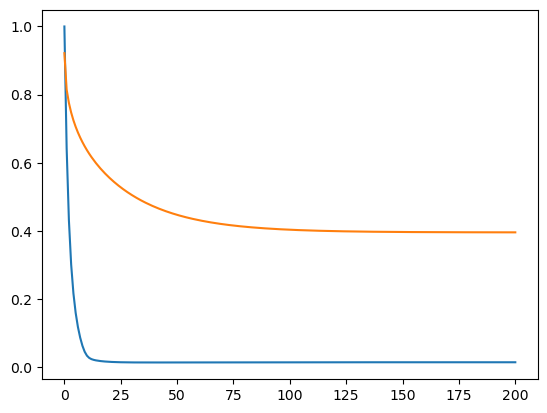

In [141]:
plt.plot(x[0].cpu().T)

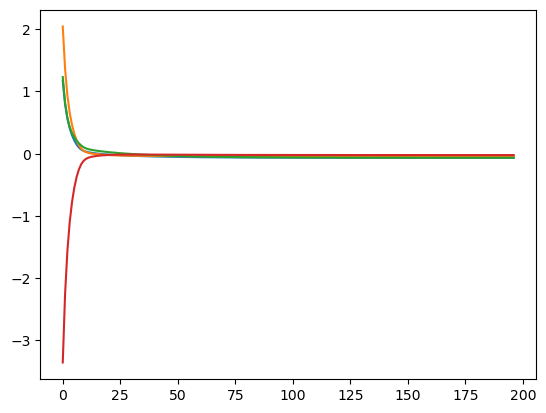

In [142]:
x1 = model.layers[0](x)
plt.plot(x1[0].cpu().detach().T);

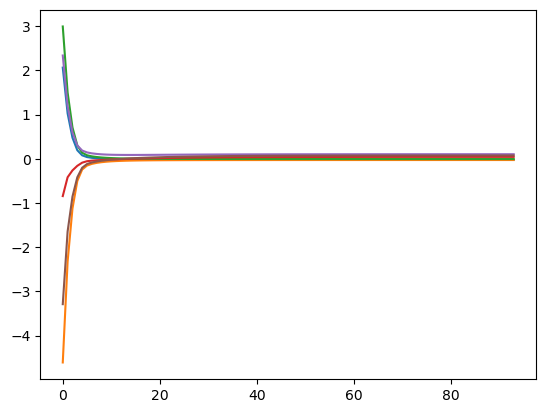

In [143]:
x2 = model.layers[1:3](x1)
plt.plot(x2[0].cpu().detach().T);

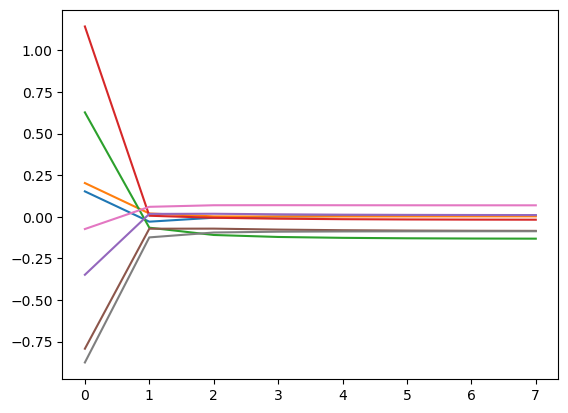

In [146]:
x3 = model.layers[3:8](x2)
plt.plot(x3[0].cpu().detach().T);